In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 77% 125M/163M [00:00<00:00, 1.31GB/s]
100% 163M/163M [00:00<00:00, 1.14GB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/face-mask-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

 **Data Preprocessing**

In [4]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from PIL import Image

In [5]:


print(os.listdir('/content/data/'))


['with_mask', 'without_mask']


In [6]:
list_of_masked_images=os.listdir('/content/data/with_mask')
list_of_unmasked_images=os.listdir('/content/data/without_mask')
print(len(list_of_masked_images))  #number of masked images
print(len(list_of_unmasked_images)) #number of unmasked images

3725
3828


In [7]:
list_of_unmasked_images[10:17]

['without_mask_3099.jpg',
 'without_mask_3556.jpg',
 'without_mask_3166.jpg',
 'without_mask_3289.jpg',
 'without_mask_1695.jpg',
 'without_mask_3290.jpg',
 'without_mask_3331.jpg']

In [8]:
list_of_masked_images[0:5]

['with_mask_2682.jpg',
 'with_mask_2207.jpg',
 'with_mask_1971.jpg',
 'with_mask_2059.jpg',
 'with_mask_526.jpg']

In [9]:
label1=[1]*3725 # 1 for masked
label2=[0]*3828 # 0 for unmasked
label=label1+label2;
len(label)

7553

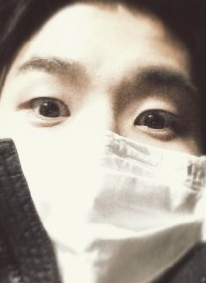

In [10]:

img=cv2.imread('/content/data/with_mask/with_mask_1152.jpg')
cv2_imshow(img)

In [11]:
with_mask_path="/content/data/with_mask/"
without_mask_path="/content/data/without_mask/"

In [12]:


data=[]
for single_image in list_of_masked_images:
  image=cv2.imread(with_mask_path+single_image)
  image=cv2.resize(image,(128,128))
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  data.append(image)

for single_image in list_of_unmasked_images:
  image=cv2.imread(without_mask_path+single_image)
  image=cv2.resize(image,(128,128))
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  data.append(image)


len(data)




7553

In [13]:
type(data)

list

In [14]:


import numpy as np
X=np.array(data)
y=np.array(label)

y[7546:7552]

array([0, 0, 0, 0, 0, 0])

In [15]:
X.shape

(7553, 128, 128, 3)

**Training the model**

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)


In [18]:

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,961 (12.64 MB)

 Trainable params: 3,312,961 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.9331 - loss: 0.2001 - val_accuracy: 0.9477 - val_loss: 0.1244
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.9437 - loss: 0.1685 - val_accuracy: 0.9557 - val_loss: 0.1223
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9356 - loss: 0.1843 - val_accuracy: 0.9643 - val_loss: 0.1220
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.9428 - loss: 0.1570 - val_accuracy: 0.9616 - val_loss: 0.1199
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.9482 - loss: 0.1457 - val_accuracy: 0.9457 - val_loss: 0.1372
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.9419 - loss: 0.1624 - val_accuracy: 0.9404 - val_loss: 0.1500
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.9534 - loss: 0.1370 - val_accuracy: 0.9669 - val_loss: 0.1049
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.9481 - loss: 0

In [ ]:
# Evaluating model for test data

loss,acc=model.evaluate(X_test_scaled,y_test)
acc
loss

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9434 - loss: 0.1716


0.1554678976535797

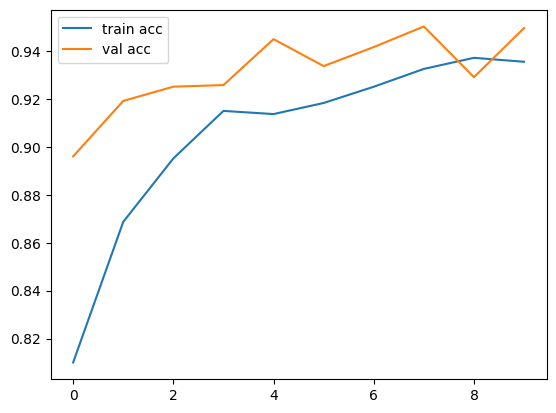

In [23]:
# Visualising accuracy

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.legend()

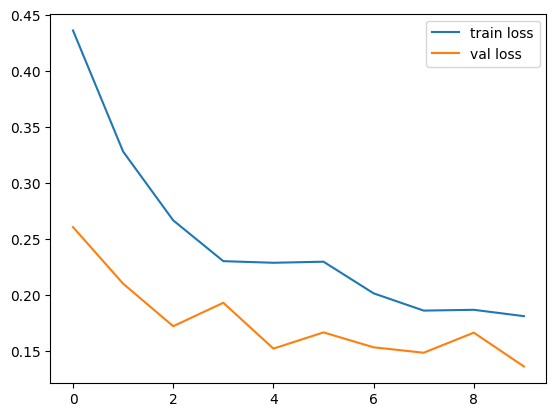

In [24]:
# Visualising  loss

plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()

**Prediction for single input image**

Path of the image: /content/data/with_mask/with_mask_1006.jpg


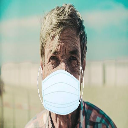

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
[[0.94706494]]
masked image


In [25]:


input_image = input("Path of the image: ")
input_r_image = cv2.imread(input_image)
image_sized = cv2.resize(input_r_image, (128, 128))
cv2_imshow(image_sized)
image_rgb = cv2.cvtColor(image_sized, cv2.COLOR_BGR2RGB)  # Match training
image_scaled = image_rgb / 255.0                           # Match normalization
image_reshaped = np.reshape(image_scaled, [1, 128, 128, 3])

prediction=model.predict(image_reshaped)
print(prediction)
score=prediction[0][0]
if(score>0.5):
  print("masked image")
else:
  print("unmasked image")


Path of the image: /content/data/without_mask/without_mask_1029.jpg


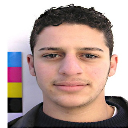

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.00023688]]
unmasked image


In [26]:


input_image = input("Path of the image: ")
input_r_image = cv2.imread(input_image)
image_sized = cv2.resize(input_r_image, (128, 128))
cv2_imshow(image_sized)
image_rgb = cv2.cvtColor(image_sized, cv2.COLOR_BGR2RGB)  # Match training
image_scaled = image_rgb / 255.0                           # Match normalization
image_reshaped = np.reshape(image_scaled, [1, 128, 128, 3])

prediction=model.predict(image_reshaped)
print(prediction)
score=prediction[0][0]
if(score>0.5):
  print("masked image")
else:
  print("unmasked image")
